In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import (
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH,
    ONE_COL_WIDTH_INCH,
    TWO_COL_GOLDEN_RATIO_HEIGHT_INCH,
)

%matplotlib inline

In [3]:
molclr = pd.read_csv("../molclr_classifcation_res.csv")
molclr["accuracy"] = molclr["acc"]
molclr_grouped = (
    molclr[molclr["name"] == "esol"].groupby(["classes", "num_size"]).agg(["mean", "std", sem])
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [4]:
molclr_grouped

Unnamed: 0                         acc                      \
                       mean         std   sem      mean       std       sem   
classes num_size                                                              
2       10              4.0         NaN   NaN  0.854545       NaN       NaN   
        20            151.0         NaN   NaN  0.854545       NaN       NaN   
        50            153.5    4.949747   3.5  0.836364  0.025713  0.018182   
        100            72.0         NaN   NaN  0.818182       NaN       NaN   
        200           135.0   80.610173  57.0  0.809091  0.012856  0.009091   
        500           103.5   17.677670  12.5  0.790909  0.038569  0.027273   
5       10            105.5  130.814755  92.5  0.727273  0.066854  0.047273   
        20            165.0         NaN   NaN  0.774545       NaN       NaN   
        50            188.0         NaN   NaN  0.796364       NaN       NaN   
        100            61.0         NaN   NaN  0.781818       NaN       NaN   
        200            63.0   57.982756  41.0  0.745455  0.071996  0.050909   
        500           128.0         NaN   NaN  0.738182       NaN       NaN   

                  f1_macro                      f1_micro                      \
                      mean       std       sem      mean       std       sem   
classes num_size                                                               
2       10        0.850543       NaN       NaN  0.854545       NaN       NaN   
        20        0.850543       NaN       NaN  0.854545       NaN       NaN   
        50        0.832866  0.025000  0.017678  0.836364  0.025713  0.018182   
        100       0.815188       NaN       NaN  0.818182       NaN       NaN   
        200       0.805433  0.013796  0.009756  0.809091  0.012856  0.009091   
        500       0.788784  0.037341  0.026404  0.790909  0.038569  0.027273   
5       10        0.318113  0.180506  0.127637  0.318182  0.167134  0.118182   
        20        0.445304       NaN       NaN  0.436364       NaN       NaN   
        50        0.493236       NaN       NaN  0.490909       NaN       NaN   
        100       0.439581       NaN       NaN  0.454545       NaN       NaN   
        200       0.369328  0.175233  0.123908  0.363636  0.179991  0.127273   
        500       0.351111       NaN       NaN  0.345455       NaN       NaN   

                  accuracy                      
                      mean       std       sem  
classes num_size                                
2       10        0.854545       NaN       NaN  
        20        0.854545       NaN       NaN  
        50        0.836364  0.025713  0.018182  
        100       0.818182       NaN       NaN  
        200       0.809091  0.012856  0.009091  
        500       0.790909  0.038569  0.027273  
5       10        0.727273  0.066854  0.047273  
        20        0.774545       NaN       NaN  
        50        0.796364       NaN       NaN  
        100       0.781818       NaN       NaN  
        200       0.745455  0.071996  0.050909  
        500       0.738182       NaN       NaN

### Load ngram baseline results

In [5]:
n_gram_baseline = glob("ngram_baseline/*.pkl")
n_gram_baseline_results = []

for f in n_gram_baseline:
    n_gram_baseline_results.append(load_pickle(f))
n_gram_baseline_results = pd.DataFrame(n_gram_baseline_results)


n_gram_baseline_results_grouped = (
    n_gram_baseline_results[
        ["num_classes", "representation", "train_size", "accuracy", "f1_micro", "f1_macro", "kappa"]
    ]
    .groupby(["num_classes", "representation", "train_size"])
    .agg(["mean", "std", sem])
)

In [6]:
n_gram_baseline_results_grouped

accuracy                      f1_micro  \
                                           mean       std       sem      mean   
num_classes representation train_size                                           
2           InChI          10          0.753968  0.041667  0.013889  0.753968   
                           20          0.750000  0.000000  0.000000  0.750000   
                           50          0.783730  0.005952  0.001984  0.783730   
                           100         0.783730  0.005952  0.001984  0.783730   
                           200         0.782143  0.007529  0.002381  0.782143   
                           500         0.765873  0.005952  0.001984  0.765873   
            SELFIES        10          0.446429  0.000000  0.000000  0.446429   
                           20          0.642857  0.000000  0.000000  0.642857   
                           50          0.625000  0.000000  0.000000  0.625000   
                           100         0.509921  0.029762  0.009921  0.509921   
                           200         0.571429  0.000000  0.000000  0.571429   
                           500         0.607143  0.000000  0.000000  0.607143   
            SMILES         10          0.490260  0.050737  0.015298  0.490260   
                           20          0.500000  0.000000  0.000000  0.500000   
                           50          0.496032  0.041667  0.013889  0.496032   
                           100         0.428571  0.000000  0.000000  0.428571   
                           200         0.593254  0.011905  0.003968  0.593254   
                           500         0.623016  0.005952  0.001984  0.623016   
5           InChI          10          0.750000  0.053571  0.017857  0.750000   
                           20          0.750000  0.000000  0.000000  0.750000   
                           50          0.785714  0.000000  0.000000  0.785714   
                           100         0.785714  0.000000  0.000000  0.785714   
                           200         0.783730  0.005952  0.001984  0.783730   
                           500         0.767857  0.000000  0.000000  0.767857   
            SELFIES        10          0.446429  0.000000  0.000000  0.446429   
                           20          0.629870  0.022716  0.006849  0.629870   
                           50          0.621032  0.011905  0.003968  0.621032   
                           100         0.515873  0.047619  0.015873  0.515873   
                           200         0.571429  0.000000  0.000000  0.571429   
                           500         0.617063  0.029762  0.009921  0.617063   
            SMILES         10          0.474206  0.029762  0.009921  0.474206   
                           20          0.500000  0.000000  0.000000  0.500000   
                           50          0.482143  0.000000  0.000000  0.482143   
                           100         0.428571  0.000000  0.000000  0.428571   
                           200         0.591270  0.005952  0.001984  0.591270   
                           500         0.625000  0.000000  0.000000  0.625000   

                                                           f1_macro            \
                                            std       sem      mean       std   
num_classes representation train_size                                           
2           InChI          10          0.041667  0.013889  0.683367  0.080126   
                           20          0.000000  0.000000  0.681301  0.000000   
                           50          0.005952  0.001984  0.735639  0.005583   
                           100         0.005952  0.001984  0.734453  0.009141   
                           200         0.007529  0.002381  0.732015  0.011563   
                           500         0.005952  0.001984  0.706878  0.009592   
            SELFIES        10          0.000000  0.000000  0.403641  0.000000   
                           20          0.000000  0.000000  0.641026  

## Load results

In [7]:
all_out = glob("out/**/*.pkl")

In [8]:
all_out = [load_pickle(p) for p in all_out]

In [9]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
graph_conv_results = []
weave_results = []
esol_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_class"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError as e:
        print(e)
        pass

    try:
        xgb_res = {
            "train_size": out["train_size"],
            "accuracy": out["xgb"]["accuracy"],
            "f1_macro": out["xgb"]["f1_macro"],
            "f1_micro": out["xgb"]["f1_micro"],
            "kappa": out["xgb"]["kappa"],
            "num_classes": out["num_class"],
        }

        tabpfn_res = {
            "train_size": out["train_size"],
            "accuracy": out["tabpfn"]["accuracy"],
            "f1_macro": out["tabpfn"]["f1_macro"],
            "f1_micro": out["tabpfn"]["f1_micro"],
            "kappa": out["tabpfn"]["kappa"],
            "num_classes": out["num_class"],
        }

        graph_conv_res = {
            "train_size": out["train_size"],
            "accuracy": out["graph_conv"]["accuracy"],
            "f1_macro": out["graph_conv"]["f1_macro"],
            "f1_micro": out["graph_conv"]["f1_micro"],
            "kappa": out["graph_conv"]["kappa"],
            "num_classes": out["num_class"],
        }

        weave_res = {
            "train_size": out["train_size"],
            "accuracy": out["weave"]["accuracy"],
            "f1_macro": out["weave"]["f1_macro"],
            "f1_micro": out["weave"]["f1_micro"],
            "kappa": out["weave"]["kappa"],
            "num_classes": out["num_class"],
        }

        esol_res = {
            "train_size": out["train_size"],
            "accuracy": out["esol"]["accuracy"],
            "f1_macro": out["esol"]["f1_macro"],
            "f1_micro": out["esol"]["f1_micro"],
            "kappa": out["esol"]["kappa"],
            "num_classes": out["num_class"],
        }

        graph_conv_results.append(graph_conv_res)
        xgboost_results.append(xgb_res)
        tabpfn_results.append(tabpfn_res)
        weave_results.append(weave_res)
        esol_results.append(esol_res)
    except KeyError as e:
        print(e)
        pass

'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'representation'
'xgb'
'frac_valid'
'xgb'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'xgb'
'xgb'
'frac_valid'
'xgb'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'xgb'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'frac_valid'
'xgb'
'xgb'
'xgb'


In [10]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)
graph_conv_res = pd.DataFrame(graph_conv_results)
weave_res = pd.DataFrame(weave_results)
esol_res = pd.DataFrame(esol_results)

In [11]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(
    ["mean", "std", sem, "count"]
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [12]:
grouped_res.to_pickle("grouped_res.pkl")

In [185]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [186]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [187]:
grouped_graph_conv_res = graph_conv_res.groupby(["num_classes", "train_size"]).agg(
    ["mean", "std", sem]
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [188]:
grouped_weave_res = weave_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [189]:
grouped_esol_res = esol_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [190]:
grouped_res.loc[2, :]

frac_valid                  accuracy            \
                                mean  std  sem count      mean       std   
representation train_size                                                  
InChI          10                1.0  0.0  0.0     3  0.666667  0.074345   
               20                1.0  NaN  NaN     1  0.678571       NaN   
               50                1.0  NaN  NaN     1  0.750000       NaN   
               200               1.0  NaN  NaN     1  0.750000       NaN   
SELFIES        10                1.0  0.0  0.0     3  0.541667  0.116186   
               20                1.0  NaN  NaN     1  0.660714       NaN   
               50                1.0  NaN  NaN     1  0.821429       NaN   
               200               1.0  NaN  NaN     1  0.714286       NaN   
SMILES         10                1.0  0.0  0.0     3  0.571429  0.053571   
               20                1.0  NaN  NaN     1  0.660714       NaN   
               50                1.0  NaN  NaN     1  0.857143       NaN   
               100               1.0  NaN  NaN     1  0.714286       NaN   
               200               1.0  NaN  NaN     1  0.767857       NaN   

                                           f1_macro                            \
                                sem count      mean       std       sem count   
representation train_size                                                       
InChI          10          0.042923     3  0.557188  0.149443  0.086281     3   
               20               NaN     1  0.657143       NaN       NaN     1   
               50               NaN     1  0.713450       NaN       NaN     1   
               200              NaN     1  0.721195       NaN       NaN     1   
SELFIES        10          0.067080     3  0.461470  0.045352  0.026184     3   
               20               NaN     1  0.536383       NaN       NaN     1   
               50               NaN     1  0.761905       NaN       NaN     1   
               200              NaN     1  0.708333       NaN       NaN     1   
SMILES         10          0.030929     3  0.480509  0.059689  0.034461     3   
               20               NaN     1  0.591868       NaN       NaN     1   
               50               NaN     1  0.825000       NaN       NaN     1   
               100              NaN     1  0.688889       NaN       NaN     1   
               200              NaN     1  0.749914       NaN       NaN     1   

                           f1_micro                               kappa  \
                               mean       std       sem count      mean   
representation train_size                                                 
InChI          10          0.666667  0.074345  0.042923     3  0.205615   
               20          0.678571       NaN       NaN     1  0.382353   
               50          0.750000       NaN       NaN     1  0.434343   
               200         0.750000       NaN       NaN     1  0.443182   
SELFIES        10          0.541667  0.116186  0.067080     3  0.099140   
               20          0.660714       NaN       NaN     1  0.198795   
               50          0.821429       NaN       NaN     1  0.536424   
               200         0.714286       NaN       NaN     1  0.416667   
SMILES         10          0.571429  0.053571  0.030929     3  0.074418   
               20          0.660714       NaN       NaN     1  0.265193   
               50          0.857143       NaN       NaN     1  0.658537   
               100         0.714286       NaN       NaN     1  0.398658   
               200         0.767857       NaN       NaN     1  0.508108   

                                                     
                                std       sem count  
representation train_size                            
InChI          10          0.204824  0.118255     3  
               20               NaN       NaN     1  
               50               NaN      

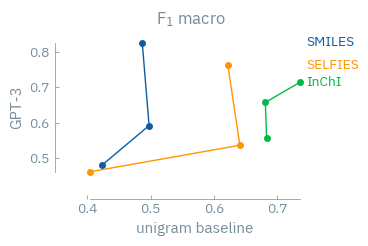

In [191]:
fig, ax = plt.subplots(figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

for representation, rn in [
    ("SMILES", "SMILES"),
    ("InChI", "InChI"),
    ("SELFIES", "SELFIES"),
]:
    ax.plot(
        n_gram_baseline_results_grouped.loc[2, representation, [10, 20, 50]]["f1_macro"]["mean"],
        grouped_res.loc[2, representation, [10, 20, 50]]["f1_macro"]["mean"],
        label=rn,
        marker="o",
        markersize=4,
    )

matplotx.line_labels(ax)

range_frame(
    ax,
    n_gram_baseline_results_grouped.loc[2, :, [10, 20, 50]]["f1_macro"]["mean"].values.reshape(
        -1, 1
    ),
    grouped_res.loc[2, :, [10, 20, 50]]["f1_macro"]["mean"].values.reshape(-1, 1),
)

ax.set_xlabel("unigram baseline")
ax.set_ylabel("GPT-3")

fig.suptitle(r"F$_1$ macro")

fig.savefig("solubility_unigram_gpt_corr.pdf", bbox_inches="tight")

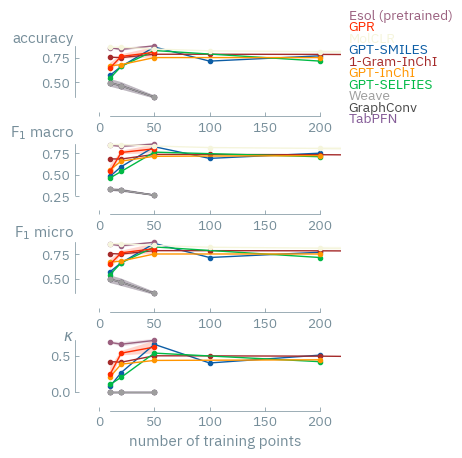

In [192]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, "SMILES", :].index,
        grouped_res.loc[2, "SMILES", :][metric]["mean"],
        marker="o",
        label="GPT-SMILES",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "SMILES", :].index,
        grouped_res.loc[2, "SMILES", :][metric]["mean"]
        - grouped_res.loc[2, "SMILES", :][metric]["sem"],
        grouped_res.loc[2, "SMILES", :][metric]["mean"]
        + grouped_res.loc[2, "SMILES", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        n_gram_baseline_results_grouped.loc[2, "InChI", :].index,
        n_gram_baseline_results_grouped.loc[2, "InChI", :][metric]["mean"],
        marker="o",
        label="1-Gram-InChI",
        c='brown'
    )

    range_frame(
        ax[i],
        grouped_res.loc[2, "SMILES", :].index,
        np.vstack(
            [
                grouped_res.loc[2, "SMILES", :][metric]["mean"].values.reshape(-1, 1),
                grouped_res.loc[2, "SELFIES", :][metric]["mean"].values.reshape(-1, 1),
                grouped_res.loc[2, "InChI", :][metric]["mean"].values.reshape(-1, 1),
                grouped_xgboost_res.loc[2, :][metric]["mean"].values.reshape(-1, 1),
                grouped_tabpfn_res.loc[2, :][metric]["mean"].values.reshape(-1, 1),
                grouped_graph_conv_res.loc[2, :][metric]["mean"].values.reshape(-1, 1),
                grouped_weave_res.loc[2, :][metric]["mean"].values.reshape(-1, 1),
                grouped_esol_res.loc[2, :][metric]["mean"].values.reshape(-1, 1),
            ]
        ).flatten(),
    )

    ax[i].plot(
        grouped_res.loc[2, "SELFIES", :].index,
        grouped_res.loc[2, "SELFIES", :][metric]["mean"],
        marker="o",
        label="GPT-SELFIES",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "SELFIES", :].index,
        grouped_res.loc[2, "SELFIES", :][metric]["mean"]
        - grouped_res.loc[2, "SELFIES", :][metric]["sem"],
        grouped_res.loc[2, "SELFIES", :][metric]["mean"]
        + grouped_res.loc[2, "SELFIES", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[2, "InChI", :].index,
        grouped_res.loc[2, "InChI", :][metric]["mean"],
        marker="o",
        label="GPT-InChI",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "InChI", :].index,
        grouped_res.loc[2, "InChI", :][metric]["mean"]
        - grouped_res.loc[2, "InChI", :][metric]["sem"],
        grouped_res.loc[2, "InChI", :][metric]["mean"]
        + grouped_res.loc[2, "InChI", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"],
        marker="o",
        label="GPR",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        - grouped_xgboost_res.loc[2, :][metric]["sem"],
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        + grouped_xgboost_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"] - grouped_tabpfn_res.loc[2, :][metric]["sem"],
        grouped_tabpfn_res.loc[2, :][metric]["mean"] + grouped_tabpfn_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_graph_conv_res.loc[2, :].index,
        grouped_graph_conv_res.loc[2, :][metric]["mean"],
        marker="o",
        label="GraphConv",
    )
    ax[i].fill_between(
        grouped_graph_conv_res.loc[2, :].index,
        grouped_graph_conv_res.loc[2, :][metric]["mean"]
        - grouped_graph_conv_res.loc[2, :][metric]["sem"],
        grouped_graph_conv_res.loc[2, :][metric]["mean"]
        + grouped_graph_conv_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_weave_res.loc[2, :].index,
        grouped_weave_res.loc[2, :][metric]["mean"],
        marker="o",
        label="Weave",
    )
    ax[i].fill_between(
        grouped_weave_res.loc[2, :].index,
        grouped_weave_res.loc[2, :][metric]["mean"] - grouped_weave_res.loc[2, :][metric]["sem"],
        grouped_weave_res.loc[2, :][metric]["mean"] + grouped_weave_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_esol_res.loc[2, :].index,
        grouped_esol_res.loc[2, :][metric]["mean"],
        marker="o",
        label="Esol (pretrained)",
    )
    ax[i].fill_between(
        grouped_esol_res.loc[2, :].index,
        grouped_esol_res.loc[2, :][metric]["mean"] - grouped_esol_res.loc[2, :][metric]["sem"],
        grouped_esol_res.loc[2, :][metric]["mean"] + grouped_esol_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    if metric != "kappa":
        ax[i].plot(
            molclr_grouped.loc[2, :].index,
            molclr_grouped.loc[2, :][metric]["mean"],
            marker="o",
            label="MolCLR",
            c='beige'
        )
        ax[i].fill_between(
            molclr_grouped.loc[2, :].index,
            molclr_grouped.loc[2, :][metric]["mean"] - molclr_grouped.loc[2, :][metric]["sem"],
            molclr_grouped.loc[2, :][metric]["mean"] + molclr_grouped.loc[2, :][metric]["sem"],
            alpha=0.2,
            color='beige'
        )


matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)

fig.savefig("solubility-classification_results_binary.pdf", bbox_inches="tight")

In [193]:
intersections = []

for i, val in enumerate(grouped_res.loc[2, "SMILES", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, "SMILES", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[2, :].index,
                grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)

intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[2, "SMILES", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, "SMILES", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[2, :].index,
                grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [194]:
find_learning_curve_intersection(
    grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

1.009384063656618

In [195]:
find_learning_curve_intersection(
    grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        molclr_grouped.loc[2, :].index,
        molclr_grouped.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

0.0015767769976959636

In [196]:
1 / find_learning_curve_intersection(
    molclr_grouped.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].index,
        grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"],
    )[0],
) / 10

0.00034625414520192513

In [197]:
grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"]

train_size
10     0.557188
20     0.657143
50     0.713450
200    0.721195
Name: mean, dtype: float64

In [198]:
molclr_grouped.loc[2, :]["f1_macro"]["mean"]

num_size
10     0.850543
20     0.850543
50     0.832866
100    0.815188
200    0.805433
500    0.788784
Name: mean, dtype: float64

In [199]:
grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"]

train_size
10    0.538507
20    0.758132
50    0.800435
Name: mean, dtype: float64

In [200]:
grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"] + grouped_tabpfn_res.loc[2, :]["f1_macro"]["sem"]

train_size
10    0.343725
20    0.333286
50    0.268394
dtype: float64

In [201]:
find_learning_curve_intersection(
    grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index.values,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"].values[::-1],
    )[0],
) / 10

21.66230037198421

In [202]:
from gptchem.evaluator import add_kappa_vlines

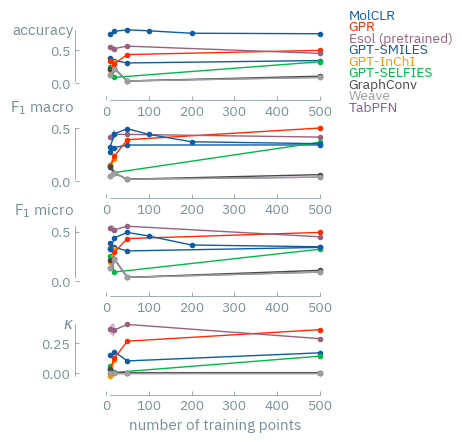

In [203]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, "SMILES", :].index,
        grouped_res.loc[5, "SMILES", :][metric]["mean"],
        marker="o",
        label="GPT-SMILES",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "SMILES", :].index,
        grouped_res.loc[5, "SMILES", :][metric]["mean"]
        - grouped_res.loc[5, "SMILES", :][metric]["sem"],
        grouped_res.loc[5, "SMILES", :][metric]["mean"]
        + grouped_res.loc[5, "SMILES", :][metric]["sem"],
        alpha=0.2,
    )

    if metric == "kappa":
        range_frame(
            ax[i],
            grouped_res.loc[5, "SMILES", :].index,
            np.vstack(
                [
                    grouped_res.loc[5, "SMILES", :][metric]["mean"].values.reshape(-1, 1),
                    grouped_res.loc[5, "SELFIES", :][metric]["mean"].values.reshape(-1, 1),
                    grouped_res.loc[5, "InChI", :][metric]["mean"].values.reshape(-1, 1),
                    grouped_xgboost_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_tabpfn_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_graph_conv_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_weave_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_esol_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                ]
            ).flatten(),
        )
    else:
        range_frame(
            ax[i],
            grouped_res.loc[5, "SMILES", :].index,
            np.vstack(
                [
                    grouped_res.loc[5, "SMILES", :][metric]["mean"].values.reshape(-1, 1),
                    grouped_res.loc[5, "SELFIES", :][metric]["mean"].values.reshape(-1, 1),
                    grouped_res.loc[5, "InChI", :][metric]["mean"].values.reshape(-1, 1),
                    grouped_xgboost_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_tabpfn_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_graph_conv_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_weave_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    grouped_esol_res.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                    molclr_grouped.loc[5, :][metric]["mean"].values.reshape(-1, 1),
                ]
            ).flatten(),
        )

    ax[i].plot(
        grouped_res.loc[5, "SELFIES", :].index,
        grouped_res.loc[5, "SELFIES", :][metric]["mean"],
        marker="o",
        label="GPT-SELFIES",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "SELFIES", :].index,
        grouped_res.loc[5, "SELFIES", :][metric]["mean"]
        - grouped_res.loc[5, "SELFIES", :][metric]["sem"],
        grouped_res.loc[5, "SELFIES", :][metric]["mean"]
        + grouped_res.loc[5, "SELFIES", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, "InChI", :].index,
        grouped_res.loc[5, "InChI", :][metric]["mean"],
        marker="o",
        label="GPT-InChI",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "InChI", :].index,
        grouped_res.loc[5, "InChI", :][metric]["mean"]
        - grouped_res.loc[5, "InChI", :][metric]["sem"],
        grouped_res.loc[5, "InChI", :][metric]["mean"]
        + grouped_res.loc[5, "InChI", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"],
        marker="o",
        label="GPR",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        - grouped_xgboost_res.loc[5, :][metric]["sem"],
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        + grouped_xgboost_res.loc[5, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"] - grouped_tabpfn_res.loc[5, :][metric]["sem"],
        grouped_tabpfn_res.loc[5, :][metric]["mean"] + grouped_tabpfn_res.loc[5, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_graph_conv_res.loc[5, :].index,
        grouped_graph_conv_res.loc[5, :][metric]["mean"],
        marker="o",
        label="GraphConv",
    )
    ax[i].fill_between(
        grouped_graph_conv_res.loc[5, :].index,
        grouped_graph_conv_res.loc[5, :][metric]["mean"]
        - grouped_graph_conv_res.loc[5, :][metric]["sem"],
        grouped_graph_conv_res.loc[5, :][metric]["mean"]
        + grouped_graph_conv_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_weave_res.loc[5, :].index,
        grouped_weave_res.loc[5, :][metric]["mean"],
        marker="o",
        label="Weave",
    )
    ax[i].fill_between(
        grouped_weave_res.loc[5, :].index,
        grouped_weave_res.loc[5, :][metric]["mean"] - grouped_weave_res.loc[5, :][metric]["sem"],
        grouped_weave_res.loc[5, :][metric]["mean"] + grouped_weave_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_esol_res.loc[5, :].index,
        grouped_esol_res.loc[5, :][metric]["mean"],
        marker="o",
        label="Esol (pretrained)",
    )
    ax[i].fill_between(
        grouped_esol_res.loc[5, :].index,
        grouped_esol_res.loc[5, :][metric]["mean"] - grouped_esol_res.loc[5, :][metric]["sem"],
        grouped_esol_res.loc[5, :][metric]["mean"] + grouped_esol_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )

    if metric != "kappa":
        ax[i].plot(
            molclr_grouped.loc[5, :].index,
            molclr_grouped.loc[5, :][metric]["mean"],
            marker="o",
            label="MolCLR",
        )
        ax[i].fill_between(
            molclr_grouped.loc[5, :].index,
            molclr_grouped.loc[5, :][metric]["mean"] - molclr_grouped.loc[5, :][metric]["sem"],
            molclr_grouped.loc[5, :][metric]["mean"] + molclr_grouped.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)


fig.savefig("solubility-classification_results_5_class.pdf", bbox_inches="tight")

In [204]:
intersections = []

for i, val in enumerate(grouped_res.loc[5, "SMILES", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, "SMILES", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[5, :].index,
                grouped_xgboost_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)

intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[5, "SMILES", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, "SMILES", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[5, :].index,
                grouped_tabpfn_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
